In [21]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [22]:
import os

PROJECT_ROOT = os.getcwd()
print("Project root:", PROJECT_ROOT)

BASE_DATASET = os.path.join(PROJECT_ROOT, "dataset")
REAL_PATH = os.path.join(BASE_DATASET, "real")
FAKE_PATH = os.path.join(BASE_DATASET, "fake")

print("Real path exists:", os.path.exists(REAL_PATH))
print("Fake path exists:", os.path.exists(FAKE_PATH))

Project root: C:\Users\vizay\PycharmProjects\PythonProject\faceforensic
Real path exists: True
Fake path exists: True


In [23]:
def collect_images_recursive(base_path):
    image_paths = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.ply')):
                image_paths.append(os.path.join(root, file))
    return image_paths

In [24]:
import os
from collections import Counter

def count_extensions(base_path):
    counter = Counter()

    for root, _, files in os.walk(base_path):
        for file in files:
            ext = os.path.splitext(file.lower())[1]
            if ext in [".jpg", ".jpeg", ".png", ".ply"]:
                counter[ext] += 1

    counter["TOTAL"] = sum(counter.values())
    return counter


real_counts = count_extensions(REAL_PATH)
fake_counts = count_extensions(FAKE_PATH)

print("REAL dataset counts:")
for k, v in real_counts.items():
    print(f"  {k} -> {v}")

print("\nFAKE dataset counts:")
for k, v in fake_counts.items():
    print(f"  {k} -> {v}")


REAL dataset counts:
  .jpg -> 165890
  .jpeg -> 6000
  TOTAL -> 171890

FAKE dataset counts:
  .png -> 26589
  .jpg -> 1117795
  .jpeg -> 120878
  .ply -> 6747
  TOTAL -> 1272009


In [25]:
import os

def collect_images_recursive(base_path):
    image_paths = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png','.ply')):
                image_paths.append(os.path.join(root, file))
    return image_paths

real_paths = collect_images_recursive(REAL_PATH)
fake_paths = collect_images_recursive(FAKE_PATH)

print("Real images:", len(real_paths))
for k, v in real_counts.items():
    print(f"  {k} -> {v}")
print("Fake images:", len(fake_paths))
for k, v in fake_counts.items():
    print(f"  {k} -> {v}")


Real images: 171890
  .jpg -> 165890
  .jpeg -> 6000
  TOTAL -> 171890
Fake images: 1272009
  .png -> 26589
  .jpg -> 1117795
  .jpeg -> 120878
  .ply -> 6747
  TOTAL -> 1272009


In [17]:
# import random
#
# # Separate paths by class
# real_paths_bal = real_paths.copy()
# fake_paths_bal = random.sample(fake_paths, len(real_paths_bal))
#
# # Rebuild dataset
# image_paths = real_paths_bal + fake_paths_bal
# labels = [0]*len(real_paths_bal) + [1]*len(fake_paths_bal)
#
# print("Balanced dataset size:", len(image_paths))
# print("New label distribution:", np.unique(labels, return_counts=True))


Balanced dataset size: 343780
New label distribution: (array([0, 1]), array([171890, 171890]))


In [26]:
import random
import numpy as np

# Target sizes
num_real = len(real_paths)
num_fake = min(len(fake_paths), 2 * num_real)

# Subsample fake
fake_paths_bal = random.sample(fake_paths, num_fake)

# Build final dataset
image_paths = real_paths + fake_paths_bal
labels = [0]*len(real_paths) + [1]*len(fake_paths_bal)

# Shuffle together
combined = list(zip(image_paths, labels))
random.shuffle(combined)
image_paths, labels = zip(*combined)

image_paths = list(image_paths)
labels = list(labels)

print("Final dataset size:", len(image_paths))
print("Label distribution:", np.unique(labels, return_counts=True))


Final dataset size: 515670
Label distribution: (array([0, 1]), array([171890, 343780]))


In [27]:

image_paths = real_paths + fake_paths
labels = [0]*len(real_paths) + [1]*len(fake_paths)

print("Total images loaded:", len(image_paths))
print("Total labels:", len(labels))

assert len(image_paths) == len(labels)


Total images loaded: 1443899
Total labels: 1443899


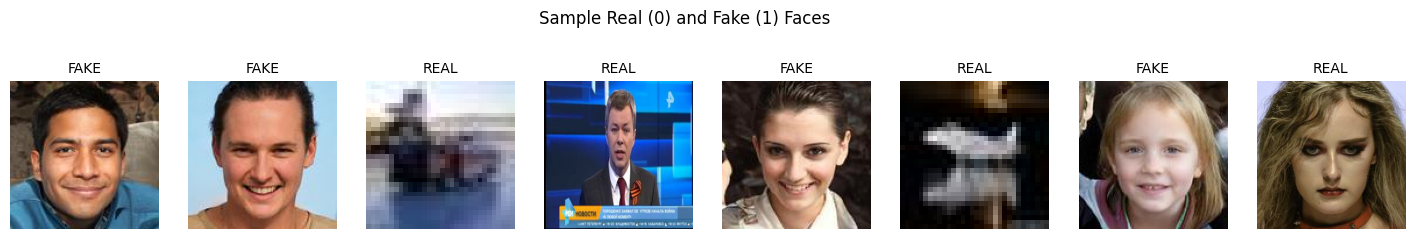

In [28]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# sample equally
real_sample = random.sample(real_paths, min(4, len(real_paths)))
fake_sample = random.sample(fake_paths, min(4, len(fake_paths)))

samples = real_sample + fake_sample
random.shuffle(samples)

plt.figure(figsize=(18, 3))
for i, path in enumerate(samples):
    img = Image.open(path)
    label ="REAL" if path in real_sample else "FAKE"
    plt.subplot(1, len(samples), i+1)
    plt.imshow(img)
    plt.title(label, fontsize=10)
    plt.axis("off")

plt.suptitle("Sample Real (0) and Fake (1) Faces")

plt.show()

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    image_paths,
    labels,
    test_size=0.3,
    stratify=labels,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print("Train:", len(X_train))
print("Validation:", len(X_val))
print("Test:", len(X_test))


Train: 1010729
Validation: 216585
Test: 216585


In [31]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),                # Better for texture learning
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.GaussianBlur(3)
    ], p=0.2),                                    # Helps generalize noise
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class AIGenDataset(Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label


In [32]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    AIGenDataset(X_train, y_train),
    batch_size=64,
    shuffle=True,
    num_workers=6

)

val_loader = DataLoader(
    AIGenDataset(X_val, y_val),
    batch_size=64,
    shuffle=False,
    num_workers=6

)

test_loader = DataLoader(
    AIGenDataset(X_test, y_test),
    batch_size=64,
    shuffle=False,
    num_workers=6
)


In [33]:
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
model.to(device)

print("Model loaded on:", device)


Model loaded on: cpu


In [ ]:
from tqdm import tqdm

EPOCHS = 16

for epoch in range(EPOCHS):
    model.train()
    correct, total = 0, 0

    for imgs, lbls in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, lbls = imgs.to(device), lbls.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct += (preds == lbls).sum().item()
        total += lbls.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1} | Train Accuracy: {train_acc:.2f}%")


Epoch 1/16:   0%|          | 0/15793 [00:00<?, ?it/s]

In [ ]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(lbls.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print("Test Accuracy:", 100 * np.mean(all_preds == all_labels))


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Real", "AI-Generated"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – AI Image Detection")
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

all_probs = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs[:, 1].cpu().numpy())

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – AI-Generated Image Detection")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
torch.save(model.state_dict(), "ai_image_detector_resnet50.pth")
print("Model saved as ai_image_detector_resnet50.pth")
